In [1]:
!wget https://github.com/hjysam/text_classification/raw/main/data/reuters21578.tar
!tar -xvf reuters21578.tar

--2023-12-18 19:47:06--  https://github.com/hjysam/text_classification/raw/main/data/reuters21578.tar
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hjysam/text_classification/main/data/reuters21578.tar [following]
--2023-12-18 19:47:06--  https://raw.githubusercontent.com/hjysam/text_classification/main/data/reuters21578.tar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28016640 (27M) [application/octet-stream]
Saving to: ‘reuters21578.tar’

reuters21578.tar    100%[===================>]  26.72M  --.-KB/s    in 0.1s    

2023-12-18 19:47:08 (217 MB/s) - ‘reuters21578.tar’ saved [28016640/280

In [2]:
!ls

all-exchanges-strings.lc.txt	    lewis.dtd	   reut2-005.sgm  reut2-012.sgm  reut2-019.sgm
all-orgs-strings.lc.txt		    README.txt	   reut2-006.sgm  reut2-013.sgm  reut2-020.sgm
all-people-strings.lc.txt	    reut2-000.sgm  reut2-007.sgm  reut2-014.sgm  reut2-021.sgm
all-places-strings.lc.txt	    reut2-001.sgm  reut2-008.sgm  reut2-015.sgm  reuters21578.tar
all-topics-strings.lc.txt	    reut2-002.sgm  reut2-009.sgm  reut2-016.sgm  sample_data
cat-descriptions_120396.txt	    reut2-003.sgm  reut2-010.sgm  reut2-017.sgm
feldman-cia-worldfactbook-data.txt  reut2-004.sgm  reut2-011.sgm  reut2-018.sgm


In [3]:
# Data manipulation and analysis
!pip install numpy
!pip install pandas
!pip install datasets

# Web scraping
!pip install beautifulsoup4

# Text processing and NLP
!pip install nltk
!pip install gensim

# Visualization
!pip install matplotlib
!pip install seaborn

# Machine learning and scikit-learn
!pip install scikit-learn
!pip install transformers

# Model persistence
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00


# Step 1: Python Module Library

In [4]:
# Standard libraries
import os
import re
from collections import Counter
from itertools import chain

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Web scraping
from bs4 import BeautifulSoup

# Text processing and NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and scikit-learn
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EvalPrediction,
    Trainer,
    TrainingArguments,
)

# Model persistence
import pickle
import torch

nltk.download('punkt')
nltk.download('stopwords')
p = print
d = display

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Step 2: Data Extraction
Downloaded From: https://archive.ics.uci.edu/dataset/137/reuters+21578+text+categorization+collection

In [5]:
def minor_preprocess(file):

  with open(file, 'rb') as f:
    lines = f.readlines()
    utf8_safe_lines = [line.decode('utf-8', 'ignore') for line in lines]
    xml_safe_lines = [re.sub(r'\d*;', '', line) for line in utf8_safe_lines] # Get rid of problematic strings
    no_newlines = [line.replace('\n', ' ') for line in xml_safe_lines]
  f.close()

  return ''.join(no_newlines)

def compile_data(datapath='/content/'):
  dataset = []
  for file in os.listdir(datapath):
    if file.endswith('.sgm'):
      preprocessed_data = minor_preprocess(datapath + '/' + file)
      records = [record + '</REUTERS>' for record in preprocessed_data.split('</REUTERS>') if record] # Retain all original formatting

      dataset.extend(records)

  return dataset


def compile_dictionary(data):
    data_dict = {
        'new_id': [],
        'people': [],
        'places': [],
        'orgs': [],
        'exchanges': [],
        'title':[],
        'body': [],
        'r_topics': [],
        'lewissplit': [],
        'cgisplit': [],
        'topic': [],
    }

    soup = BeautifulSoup(data, 'xml')

    reuters_tag = soup.find('REUTERS')
    if reuters_tag:
        r_topics_value = reuters_tag.get('TOPICS')
        if r_topics_value:
            data_dict['r_topics'] = r_topics_value

        new_id_value = reuters_tag.get('NEWID')
        if new_id_value:
            data_dict['new_id'] = new_id_value

        lewissplit_value = reuters_tag.get('LEWISSPLIT')
        if lewissplit_value:
            data_dict['lewissplit'] = lewissplit_value

        cgisplit_value = reuters_tag.get('CGISPLIT')
        if cgisplit_value:
            data_dict['cgisplit'] = cgisplit_value

    people_tag = soup.find('PEOPLE')
    if people_tag and people_tag.contents:
        cleaned_people = [tag.text for tag in people_tag.find_all('D')]
        data_dict['people'] = cleaned_people

    places_tag = soup.find('PLACES')
    if places_tag and places_tag.contents:
        cleaned_places = [tag.text for tag in places_tag.find_all('D')]
        data_dict['places'] = cleaned_places

    orgs_tag = soup.find('ORGS')
    if orgs_tag and orgs_tag.contents:
        cleaned_orgs = [tag.text for tag in orgs_tag.find_all('D')]
        data_dict['orgs'] = cleaned_orgs

    exchanges_tag = soup.find('EXCHANGES')
    if exchanges_tag and exchanges_tag.contents:
        cleaned_exc = [tag.text for tag in exchanges_tag.find_all('D')]
        data_dict['exchanges'] = cleaned_exc

    body_tag = soup.find('BODY')
    if body_tag and body_tag.contents:
        data_dict['body'] = body_tag.contents[0]

    title_tag = soup.find('TITLE')
    if title_tag and title_tag.contents:
        data_dict['title'] = title_tag.contents[0]

    topics_tag = soup.find('TOPICS')
    if topics_tag and topics_tag.contents:
        cleaned_topics = [tag.text for tag in topics_tag.find_all('D')]
        data_dict['topic'] = cleaned_topics

    return data_dict


In [6]:
# Convert the list into a dictionary with fields of interest
reuters_dicts = [compile_dictionary(data) for data in compile_data()]


In [7]:
df = pd.DataFrame(reuters_dicts)
d(df.head())
df.to_csv('raw_data.csv')

,new_id,people,places,orgs,exchanges,title,body,r_topics,lewissplit,cgisplit,topic
0,2001,[],[uk],[],[],JAGUAR SEES STRONG GROWTH IN NEW MODEL SALES,Jaguar Plc > is about to sell its new XJ-6 mod...,YES,TRAIN,TRAINING-SET,[earn]
1,2002,[],[],[],[],OCCIDENTAL PETROLEUM COMMON STOCK OFFERING RAI...,[],NO,TRAIN,TRAINING-SET,[]
2,2003,[],"[usa, iraq]",[],[],CCC ACCEPTS BONUS BID ON WHEAT FLOUR TO IRAQ,"The Commodity Credit Corporation, CCC, has acc...",YES,TRAIN,TRAINING-SET,"[grain, wheat]"
3,2004,[],[],[],[],DIAMOND SHAMROCK RAISES CRUDE POSTED PRICES ON...,[],YES,TRAIN,TRAINING-SET,[crude]
4,2005,[],[usa],[],[],NORD RESOURCES CORP > 4TH QTR NET,"Shr 19 cts vs 13 cts Net 2,656,000 vs 1,71...",YES,TRAIN,TRAINING-SET,[earn]


Dataset Overview

In [8]:
p('Statistical Table')
d(df.describe())

p('\nData Type for each Column')
d(df.info())

# Check for empty lists in each column
p('\nNumber of empty list in each column')
d(df.applymap(lambda x: isinstance(x, list) and not x).sum())


Statistical Table


,new_id,people,places,orgs,exchanges,title,body,r_topics,lewissplit,cgisplit,topic
count,21600,21600,21600,21600,21600,21600,21600,21600,21600,21600,21600
unique,21579,218,1097,68,58,20006,18780,4,4,3,656
top,[],[],[usa],[],[],[],[],YES,TRAIN,TRAINING-SET,[]
freq,22,20444,10878,20719,21118,759,2557,13476,14668,20856,10233



Data Type for each Column
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21600 entries, 0 to 21599
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   new_id      21600 non-null  object
 1   people      21600 non-null  object
 2   places      21600 non-null  object
 3   orgs        21600 non-null  object
 4   exchanges   21600 non-null  object
 5   title       21600 non-null  object
 6   body        21600 non-null  object
 7   r_topics    21600 non-null  object
 8   lewissplit  21600 non-null  object
 9   cgisplit    21600 non-null  object
 10  topic       21600 non-null  object
dtypes: object(11)
memory usage: 1.8+ MB


None


Number of empty list in each column


new_id           22
people        20444
places         2802
orgs          20719
exchanges     21118
title           759
body           2557
r_topics         22
lewissplit       22
cgisplit         22
topic         10233
dtype: int64

Since there is a significant number of empty lists for people, organizations, and exchanges, we have decided to drop these columns. Additionally, places are not expected to contribute significantly to the topic classification task, therefore, this column will also be removed.

As a result:
- the selected features are 'title' and 'body'
- the label is 'topic'.

Next, check if the data size is extracted correctly based on different split methods.

In [9]:
p('The Modified Apte ("ModApte") Split')
p('train size: ' + str(len(df[(df.lewissplit=='TRAIN') & (df.r_topics=='YES')])))
p('test size: ' + str(len(df[(df.lewissplit=='TEST') & (df.r_topics=='YES')])))
p('not-used size: ' + str(len(df[df.lewissplit=='NOT-USED'])))
p()

p('The Modified Hayes ("ModHayes") Split')
p('train size: ' + str(len(df[df.cgisplit=='TRAINING-SET'])))
p('test size: ' + str(len(df[df.cgisplit=='PUBLISHED-TESTSET'])))
p('not-used size: ' + str(len(df[df.cgisplit=='NOT-USED'])))

The Modified Apte ("ModApte") Split
train size: 9603
test size: 3299
not-used size: 722

The Modified Hayes ("ModHayes") Split
train size: 20856
test size: 722
not-used size: 0


The size mentioned above aligns with the information provided in the dataset readme file, confirming that there are no mistakes in the data extraction. Please refer to:

- Line 459: VIII.B. The Modified Apte ('ModApte') Split
- Line 510: VIII.C. The Modified Hayes ('ModHayes') Split

For simplicity, we will choose ModApte over ModHayes, as it offers a more balanced distribution of training (9603) and testing (3299) data sizes, equivalent to a ratio of 65% versus 35%.

# Step 3: Data Preprocessing

Combine title and body together as text column

In [10]:
p("Combine title and body together")
df['text'] = df['title'].apply(lambda x: ''.join(x)) + ' '  + df['body'].apply(lambda x: ''.join(x))
df.insert(df.columns.get_loc('body') + 1, 'text', df.pop('text'))
df = df.drop(['body', 'title'], axis=1)

Combine title and body together


Remove special characters, newlines and number

In [11]:
df['text'] = df['text'].replace('[^a-zA-Z0-9\s]', '', regex=True)       # Special Characters
df['text'] = df['text'].replace('\n', ' ', regex=True)                  # Remove newlines
df['text'] = df['text'].replace('\d', '', regex=True)                   # Remove numbers


Removing stopwords through tokenization

In [12]:
# Define function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply the function to the DataFrame
df['text'] = df['text'].apply(remove_stopwords)


Stemming through tokenizing

In [13]:
# Initialize Porter Stemmer
ps = PorterStemmer()

# Define function to apply stemming
def apply_stemming(text):
    words = word_tokenize(text)
    stemmed_words = [ps.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Apply the function to the DataFrame
df['text'] = df['text'].apply(apply_stemming)


Result of the text columns after preprocessing

In [14]:
df.text.head()

0    jaguar see strong growth new model sale jaguar...
1    occident petroleum common stock offer rais mln...
2    ccc accept bonu bid wheat flour iraq commod cr...
3    diamond shamrock rais crude post price one dlr...
4    nord resourc corp th qtr net shr ct vs ct net ...
Name: text, dtype: object

Recreate a new data dictionery based on ModApte split; for more information, refer to step 2 for the reason.
 - Train
 - Test
 - Unused

In [15]:
#Create a new function to cater for ModApte split for data dict
def create_data_dict(df, lewissplit, r_topics):
    data_dict = {
        'text': df[(df.lewissplit == lewissplit) & (df.r_topics == r_topics)].text.to_list(),
        'topic': df[(df.lewissplit == lewissplit) & (df.r_topics == r_topics)].topic.to_list(),
    }
    return data_dict

# 'test' dict
test_dict = create_data_dict(df, 'TEST', 'YES')

# 'train' dict
train_dict = create_data_dict(df, 'TRAIN', 'YES')

# 'unused' dict (Will not be ignored)
unused_dict = create_data_dict(df, 'NOT-USED', '')

# Step 4: Data Exploration / Cleaning  

Word Frequency Analysis for Text
- Identify the most frequent words.
- Identify the words that appear for one time.
- Count the number of unique words

In [16]:
from nltk.tokenize import word_tokenize
from collections import Counter

# List of sentences
sentences = train_dict['text']

# Tokenize the text
all_tokens = [word_tokenize(sentence) for sentence in sentences]

# Flatten the list of tokens
all_tokens_flat = [token for sublist in all_tokens for token in sublist]

# Create a Counter to count word frequencies
word_freq = Counter(all_tokens_flat)

# Identify the most frequent words (top N)
most_frequent_words = word_freq.most_common(10)

# Find words that appear only once
words_appear_one_time = [word for word, freq in word_freq.items() if freq == 1]

# Count the number of unique words
num_unique_words = len(word_freq)

# Display the results
p("Most Frequent Words:")
p(most_frequent_words)
p("\nNumber of Words Appear for One Time:")
p(len(words_appear_one_time ))
p('\nExample of Words Appear for One Time')
p(words_appear_one_time)
p("\nNumber of Unique Words:", num_unique_words)


Most Frequent Words:
[('said', 23727), ('mln', 15324), ('dlr', 12669), ('pct', 9805), ('reuter', 9193), ('vs', 9187), ('year', 7138), ('bank', 6485), ('ct', 5857), ('billion', 5450)]

Number of Words Appear for One Time:
7469

Example of Words Appear for One Time
['init', 'barcelo', 'gloeilampenfabriek', 'kph', 'anatolia', 'ataturk', 'seeker', 'tb', 'withdrfaw', 'taiwain', 'resourec', 'interesdt', 'automedix', 'tohe', 'operationg', 'beau', 'bolter', 'wirtschaftswoch', 'sachss', 'orca', 'semist', 'bbd', 'welleveryth', 'felip', 'gonzalez', 'maximium', 'gambro', 'culpabl', 'homicid', 'suffoc', 'witbank', 'resourcebas', 'comnon', 'mikulski', 'corpror', 'ruchlam', 'kof', 'piggyback', 'asaback', 'unitil', 'exlcud', 'icomemb', 'crutch', 'francophon', 'greed', 'dmass', 'distress', 'disbar', 'norinchukin', 'lifter', 'extraordinrari', 'sevenst', 'technisch', 'physik', 'atomika', 'eden', 'francico', 'tucsonm', 'mortgagesback', 'tmc', 'endowmentlink', 'oestasiatisk', 'kompagni', 'conchemco', 'winl

- As stopwords have applied on previous step, so there isn't any more words like the, will and is.  
- There are 7231 words that appear for one time as compared to a total of 19737 unique words

Label Analysis
- Topic is considered as the label for this text classification

Average token for each element
1.0047901697386235

Number of unique topic
115

Density
0.008737305823814117

Topic that Occurence for only one time
20

topic occurences for one time
['cruzado', 'corn-oil', 'peseta', 'sun-meal', 'lin-meal', 'skr', 'nkr', 'dkr', 'ringgit', 'cotton-oil', 'lin-oil', 'rye', 'red-bean', 'groundnut-oil', 'citruspulp', 'rape-meal', 'castorseed', 'castor-oil', 'lit', 'rupiah']


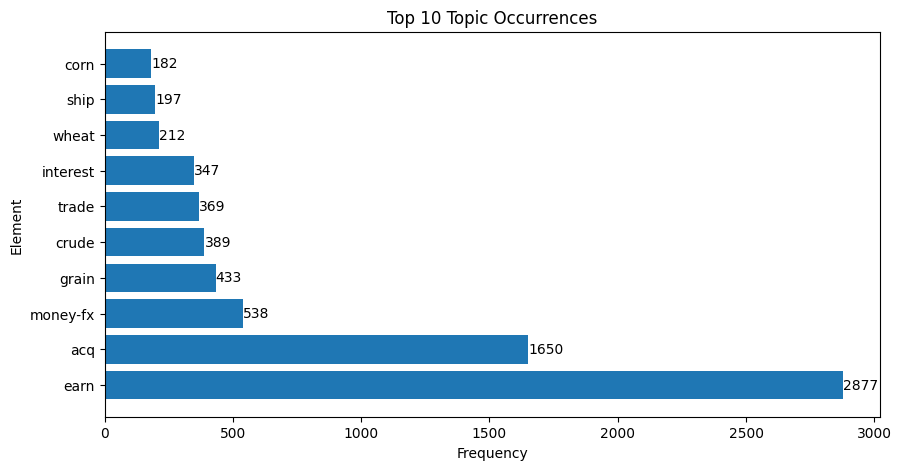

In [17]:
# Topic list
my_list = train_dict['topic']

p('Average token for each element')
average_token_per_element = sum([len(element) for element in my_list])/len(my_list)
p(average_token_per_element)

# Flatten the list of lists
flattened_list = [item for sublist in my_list for item in sublist]

# Use Counter to count occurrences
element_counts = Counter(flattened_list)
p('\nNumber of unique topic')
p(len(element_counts))

p('\nDensity')
p(average_token_per_element/len(element_counts))

# Sort the items by frequency in descending order
sorted_counts = sorted(element_counts.items(), key=lambda x: x[1], reverse=True)

p('\nTopic that Occurence for only one time')
filtered_counts = [item for item in sorted_counts if item[1] == 1]
p(len([item[0] for item in filtered_counts ]))

p("\ntopic occurences for one time")
# Filter tuples where the value is equal to 1
occurance_only_one = [element[0] for element in filtered_counts]
p(occurance_only_one)

# Extract & plot top 10
top_10 = sorted_counts[:10]
plt.figure(figsize=(10, 5))
bars = plt.barh(range(len(top_10)), [count for _, count in top_10], align='center')

# Add labels to the bars
for bar, (item, count) in zip(bars, top_10):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{count}', ha='left', va='center')

plt.yticks(range(len(top_10)), [item for item, _ in top_10])
plt.title('Top 10 Topic Occurrences')
plt.xlabel('Frequency')
plt.ylabel('Element')
plt.show()


Check if we can remove some of the one-time occurance by comparing to test set

In [18]:
# Initialize a list to store samples with one time occurance labels
topic_occurence_one_test = []

for sample in test_dict['topic']:
    if any(label in occurance_only_one for label in sample):
        topic_occurence_one_test.append(sample)

p('Number of topic occurence one time in test')
p(len(topic_occurence_one_test),'out of', len(test_dict['text']))
p('\nShare in percentage')
p(str(round(len(topic_occurence_one_test)/len(test_dict['text'])*100,2)) + '%')

Number of topic occurence one time in test
7 out of 3299

Share in percentage
0.21%


Safe to drop these one-time occurrance for train and test to reduce the label size.

In [19]:
def remove_unwanted_topic(dict):
    df1 = pd.DataFrame(dict)
    df1 = df1[~df1['topic'].apply(lambda x: any(topic in x for topic in occurance_only_one))]
    return df1.to_dict(orient='list')

train_dict = remove_unwanted_topic(train_dict)
test_dict = remove_unwanted_topic(test_dict)

p('new number of train data', len(train_dict['text']) )
p('new number of test data',len(test_dict['text']))


new number of train data 9588
new number of test data 3292


# Step 5: Prediction based on Classifier Model

This code prepares training data by extracting text (x_train) and corresponding topics (y_train). It then transforms the text into numerical vectors using TF-IDF, and the topics into a binary matrix, facilitating the training of machine learning models.

In [20]:
# Custom transformer to convert text to Word2Vec embeddings
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.model.wv[x] if x in self.model.wv else [0] * self.model.vector_size for x in X]

In [21]:
x_train, y_train = train_dict['text'], train_dict['topic']
x_test, y_test = test_dict['text'], test_dict['topic']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
vectorizer.fit(x_train)

# Word2Vec Model
word2vec_model = Word2Vec(sentences=x_train, vector_size=100, window=5, min_count=1, workers=4)

# Create a pipeline with both transformations
combined_features = FeatureUnion([
    ('tfidf', vectorizer),
    ('word2vec', Word2VecTransformer(word2vec_model))
])

# Combined_features as pickle
with open('combined_features.sav', 'wb') as combined_features_file:
    pickle.dump(combined_features, combined_features_file)

# Transform the data
X_train_combined = combined_features.fit_transform(x_train)
X_test_combined = combined_features.transform(x_test)


# Transform Labels to Binary Matrix
mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(y_train)
y_test_bin = mlb.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['cottonseed', 'f-cattle', 'sfr'] will be ignored
  warnings.warn(


 Transforms test text data (test_dict['text']) into numerical vectors using the pre-trained TF-IDF vectorizer. It also converts test topics (test_dict['topic']) into a binary matrix using the MultiLabelBinarizer. Finally, it prints the classes (unique topics) present in the binary matrix, providing insight into the labeled topics used in testing.

In [22]:
p(mlb.classes_)

['acq' 'alum' 'austdlr' 'barley' 'bop' 'can' 'carcass' 'cocoa' 'coconut'
 'coconut-oil' 'coffee' 'copper' 'copra-cake' 'corn' 'cornglutenfeed'
 'cotton' 'cpi' 'cpu' 'crude' 'dfl' 'dlr' 'dmk' 'earn' 'fishmeal' 'fuel'
 'gas' 'gnp' 'gold' 'grain' 'groundnut' 'heat' 'hog' 'housing' 'income'
 'instal-debt' 'interest' 'inventories' 'ipi' 'iron-steel' 'jet' 'jobs'
 'l-cattle' 'lead' 'lei' 'linseed' 'livestock' 'lumber' 'meal-feed'
 'money-fx' 'money-supply' 'naphtha' 'nat-gas' 'nickel' 'nzdlr' 'oat'
 'oilseed' 'orange' 'palladium' 'palm-oil' 'palmkernel' 'pet-chem'
 'platinum' 'plywood' 'pork-belly' 'potato' 'propane' 'rand' 'rape-oil'
 'rapeseed' 'reserves' 'retail' 'rice' 'rubber' 'saudriyal' 'ship'
 'silver' 'sorghum' 'soy-meal' 'soy-oil' 'soybean' 'stg' 'strategic-metal'
 'sugar' 'sun-oil' 'sunseed' 'tapioca' 'tea' 'tin' 'trade' 'veg-oil'
 'wheat' 'wool' 'wpi' 'yen' 'zinc']


Training multiple classifiers is advantageous for diverse insights and enhanced performance which provides robustness, balances bias and variance trade-offs, and allows for exploratory analysis, ultimately contributing to a more versatile and reliable machine learning system. Due to limited time, only 3 classifers are run to give the quick result.  

In [23]:
#Wait for more than 1min to run

classifiers = [
    OneVsRestClassifier(LogisticRegression(random_state=0)),
    OneVsRestClassifier(SGDClassifier(alpha=0.0001, random_state=0)),
    OneVsRestClassifier(MultinomialNB(alpha=0.1)),
    #OneVsRestClassifier(RandomForestClassifier(n_estimators=50, max_depth=3, random_state=0)),
    #OneVsRestClassifier(SVC(kernel='linear', C=1.0, random_state=0)),
    #OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, alpha=0.0001, solver='adam', random_state=0))

]

entries = []
cv_df = pd.DataFrame()
for clf in classifiers:
    print(str(clf))
    scores = cross_val_score(clf, X_train_combined, y_train_bin, cv=5, scoring='accuracy')
    for fold_idx, accuracy in enumerate(scores):
        entries.append((clf.estimator, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['classifier', 'fold_idx', 'accuracy'])

OneVsRestClassifier(estimator=LogisticRegression(random_state=0))


/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 5 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 23 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 34 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 57 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 17 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 44 is present in all training exampl

OneVsRestClassifier(estimator=SGDClassifier(random_state=0))


/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 5 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 23 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 34 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 57 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 17 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 44 is present in all training exampl

OneVsRestClassifier(estimator=MultinomialNB(alpha=0.1))


/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 5 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 14 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 23 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 34 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 57 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 17 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/multiclass.py:77: UserWarning: Label not 44 is present in all training exampl

Accuracy table for different classifiers

Best classifier is SGD

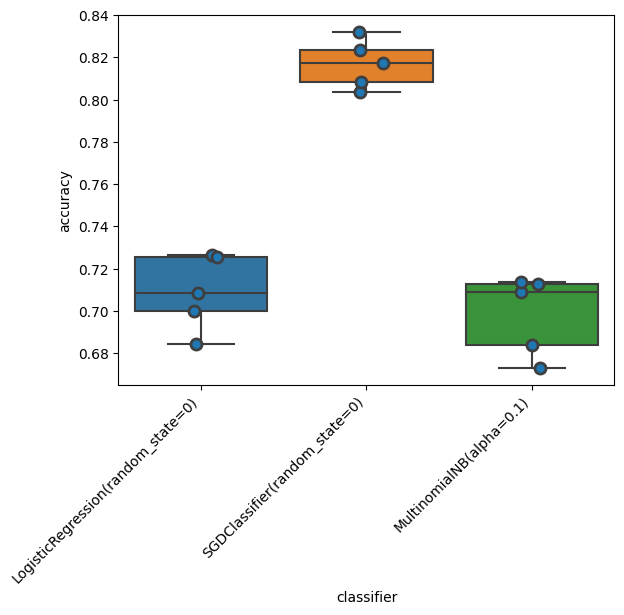

In [24]:
# Your existing code for creating the boxplot
cv_df['classifier'] = cv_df['classifier'].astype(str)
sns.boxplot(x='classifier', y='accuracy', data=cv_df)
sns.stripplot(x='classifier', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)

# Shorten x-axis labels
plt.xticks(rotation=45, ha='right')  # Adjust the rotation angle as needed

plt.show()

In [25]:
# Train Classifier
clf = OneVsRestClassifier(SGDClassifier(alpha=0.0001, random_state=0))
clf.fit(X_train_combined, y_train_bin)
# Predictions and Evaluation
y_pred = clf.predict(X_test_combined)

In [26]:
print("Classification Report:")
print(classification_report(y_test_bin, y_pred, target_names=mlb.classes_, zero_division=1))

Classification Report:
                 precision    recall  f1-score   support

            acq       0.98      0.92      0.95       719
           alum       1.00      0.52      0.69        23
        austdlr       1.00      1.00      1.00         0
         barley       1.00      0.75      0.86        12
            bop       0.95      0.60      0.73        30
            can       1.00      1.00      1.00         0
        carcass       0.83      0.56      0.67        18
          cocoa       1.00      0.94      0.97        18
        coconut       1.00      0.50      0.67         2
    coconut-oil       1.00      0.00      0.00         2
         coffee       0.93      1.00      0.96        27
         copper       1.00      0.89      0.94        18
     copra-cake       1.00      0.00      0.00         1
           corn       0.97      0.71      0.82        55
 cornglutenfeed       1.00      1.00      1.00         0
         cotton       1.00      0.61      0.76        18
       

Classification Report Analysis

The classification report highlights the model's proficiency in specific topics, as evident from high precision, recall, and F1-scores. For example, the 'acq' topic boasts a precision of 0.98, recall of 0.93, and an F1-score of 0.95. However, the model's performance is unevenly distributed across various topics.

The macro average for recall and F1-score, standing at 0.49 and 0.55 respectively, suggests an opportunity to enhance the model's performance on minority classes.

Conversely, the weighted average, signaling high precision (0.95), recall (0.80), and F1-score (0.84), indicates effective performance on common topics. Yet, this may not accurately represent the model's efficacy on less frequent topics.

The samples average, portraying elevated precision (0.97), recall (0.87), and F1-score (0.86), demonstrates commendable performance on individual instances. However, it might not fully encapsulate the model's effectiveness for each specific topic.

In summary, while the model excels in specific areas, there exists room for improvement, particularly in achieving a more balanced performance across all topics.


Save the classifier model as pickle file

In [27]:
# Save the model to a file
with open('classifier.sav', 'wb') as file:
    pickle.dump(clf, file)

Classifer Prediction

In [28]:
#When handling the list for new text input
def preprocess_text_advanced(text_input):
    # If text_input is a list, process each element separately
    if isinstance(text_input, list):
        processed_texts = []
        for single_text in text_input:
            # Process each element using the single-text processing function
            processed_text = preprocess_text_advanced_single(single_text)
            processed_texts.append(processed_text)
        return processed_texts
    else:
        # If text_input is a single string, process it directly
        return preprocess_text_advanced_single(text_input)

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

#When handling the single for new text input
def preprocess_text_advanced_single(text_input):
    # Lowercasing
    text_input = text_input.lower()

    # Removing HTML tags (if any)
    text_input = re.sub(r'<.*?>', '', text_input)

    # Removing special characters, numbers, and newlines
    text_input = re.sub(r'[^a-zA-Z\s]', '', text_input)
    text_input = re.sub(r'\d+', '', text_input)
    text_input = text_input.replace('\n', ' ')

    # Tokenization
    tokens = word_tokenize(text_input)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in tokens]

    # Joining tokens back into a string
    preprocessed_text = ' '.join(stemmed_words)

    return preprocessed_text

def classifier_topic_prediction(text_input):

    # Preprocess the new text
    processed_text = preprocess_text_advanced(text_input)

    # Load the TF-IDF vectorizer (already fitted on your training data)
    with open('combined_features.sav', 'rb') as combined_features_file:
        combined_features = pickle.load(combined_features_file)

    # Transform the data
    X_test_combined = combined_features.transform(processed_text)

    #Load the classifier model
    with open('classifier.sav', 'rb') as classifer_model:
        classifier = pickle.load(classifer_model)

    # Predict the topic
    one_hot_array = classifier.predict(X_test_combined)
    position = np.argmax(one_hot_array)
    p('Predicted Topic: ', mlb.classes_[position])


def classifier_topic_prediction_array(text_input):

    if len(text_input) > 1:

        for i in text_input:
            classifier_topic_prediction([i])

    else:
        classifier_topic_prediction(text_input)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Prepared 3 kinds of Texts:
 - train_text (Extracted from train data)
 - new_text (Copy from internet)
 - test_text_array (Extracted from test data)

In [29]:
train_text = ["""The U.S. Agriculture Department
reported the farmer-owned reserve national five-day average
price through February 25 as follows (Dlrs/Bu-Sorghum Cwt) -
         Natl   Loan           Release   Call
         Avge   Rate-X  Level    Price  Price
 Wheat   2.55   2.40       IV     4.65     --
                            V     4.65     --
                           VI     4.45     --
 Corn    1.35   1.92       IV     3.15   3.15
                            V     3.25     --
 X - 1986 Rates.

          Natl   Loan          Release   Call
          Avge   Rate-X  Level   Price  Price
 Oats     1.24   0.99        V    1.65    --
 Barley   n.a.   1.56       IV    2.55   2.55
                             V    2.65    --
 Sorghum  2.34   3.25-Y     IV    5.36   5.36
                             V    5.54    --
    Reserves I, II and III have matured. Level IV reflects
grain entered after Oct 6, 1981 for feedgrain and after July
23, 1981 for wheat. Level V wheat/barley after 5/14/82,
corn/sorghum after 7/1/82. Level VI covers wheat entered after
January 19, 1984.  X-1986 rates. Y-dlrs per CWT (100 lbs).
n.a.-not available."""]

new_text = ["""TBEIJING: China is set to showcase the strides made towards self-reliance at an inaugural global trade fair this week, even as it looks to attract companies and shore up faltering foreign investments in the face of a slowing economy.

The participation of Western businesses at the China International Supply Chain Expo will also be in focus as Sino-US ties warm up following high-stakes talks between the countries’ leaders earlier this month.

China has promoted the five-day event - which begins in Beijing on Nov 28 - as the world’s first supply chain expo at the national level.

It will be the latest in a series of global trade shows China has held in the second half of the year. At least two have already taken place this month alone, the most recent being the Global Digital Trade Expo in Hangzhou last week.

Chinese state media have framed these events as a sign of Beijing’s contributions to the global economy and its commitment to international trade.

A quarter of the 515 companies and institutions participating in the supply chain expo are foreign, hailing from 55 countries and regions, said event organiser the China Council for the Promotion of International Trade (CCPIT).

US firms make up around 20 per cent of the foreign registrations, with the likes of Amazon, Apple, Tesla, Intel, HP and Qualcomm among the line-up. European companies make up 15 per cent.

The number of US exhibitors is “much higher than expected”, according to the expo organiser.

We hope that the participating US companies actively engage in the expo, yielding fruitful outcomes," said CCPIT Vice-Chairman Mr Zhang Shaogang in a press conference last week.

We will continue to vigorously promote high-level opening up and better protect the rights and interests of foreign investors per the law.."""]

test_text_array =  ['indonesian commod exchang may expand indonesian commod exchang like start trade least one new commod possibl two calendar exchang chairman paian nainggolan said told reuter telephon interview trade palm oil sawn timber pepper tobacco consid trade either crude palm oil cpo refin palm oil may also introduc said question still consid trade minist rachmat saleh decis go ahead made fledgl exchang current trade coffe rubber physic open outcri system four day week sever factor make us move cautious nainggolan said want move slowli safe make mistak undermin confid exchang physic rubber trade launch coffe ad januari rubber contract trade fob five month forward robusta coffe grade four five trade prompt deliveri five month forward exchang offici said trade ministri exchang board consid introduct futur trade later rubber one offici said feasibl studi need first decis like indonesia elect april trader said trade minist saleh said monday indonesia world second largest produc natur rubber expand rubber market effort hope develop exchang would help nainggolan said exchang tri boost oversea interest build contact endus said team alreadi south korea taiwan encourag direct use exchang deleg would also visit europ mexico latin american state encourag particip offici say infant exchang made good start although trade coffe disappoint transact rubber start trade april decemb total tonn worth mln dlr fob plu mln rupiah rubber deliv local latest exchang report said trade coffe calendar amount tonn lot valu billion rupiah total membership exchang nine broker trader reuter','sri lanka get usda approv wheat price food depart offici said us depart agricultur approv continent grain co sale tonn soft wheat us dlr tonn c f pacif northwest colombo said shipment april deliveri reuter','western mine open new gold mine australia western mine corp hold ltd wmc said establish new joint ventur gold mine northern territori cost mln dlr mine known goodal project own pct wmc pct local wr grace co unit locat km east adelaid river mt bundey wmc said statement said openpit mine convent leach treatment plant expect produc ounc gold first year product mid annual ore capac tonn reuter','sumitomo bank aim quick recoveri merger sumitomo bank ltd certain lose statu japan profit bank result merger heiwa sogo bank financi analyst said osakabas sumitomo desposit around trillion yen merg heiwa sogo small struggl bank estim billion dlr unrecover loan octob despit linkup sumitomo presid koh komatsu told reuter confid bank quickli regain posit well back posit first place within three year komatsu said interview said merger initi reduc sumitomo profit effici vastli expand sumitomo branch network tokyo metropolitan area rel weak financi analyst divid whether quickli gambl pay said sumitomo may paid much heiwa sogo view smaller bank larg debt other argu merger cost effect creat compar branch network scratch analyst agre bank aggress expand oversea enter lucr secur busi gear domest competit question wisdom move theyv made bold move put everyth place larg hand said kleinwort benson ltd financi analyst simon smithson among sumitomo problem limit place move enter us secur busi take share american invest bank goldman sach co sumitomo last august agre pay mln dlr pct limit partnership bank time least feder reserv board forbidden exchang personnel increas busi tieup wide look lame duck fed stricter sumitomo expect said one analyst komatsu said move pay time us regul chang near futur variou thing wait two three year st centuri komatsu said komatsu also will patient possibl rout secur busi home articl secur exchang act japan version us glasssteagal act separ commerci invest bank wall two crumbl komatsu said hope deregul creat new opportun need find new busi chanc komatsu said case secur relat case trust bank relat that kind deregul want chang occur sumitomo focu domest secur busi profit govern bond deal strengthen relat meiko secur co ltd hold five pct share komatsu said said sumitomo cautious optimist enter']



In [30]:
p('Classifier')
p()
classifier_topic_prediction_array(train_text)
p()
classifier_topic_prediction_array(new_text)
p()
classifier_topic_prediction_array(test_text_array)

Classifier

Predicted Topic:  barley

Predicted Topic:  trade

Predicted Topic:  rubber
Predicted Topic:  grain
Predicted Topic:  gold
Predicted Topic:  acq


# Step 6: Prediction based on BERT Transformer


To execute Step 6, make sure to open the IPython notebook in Google Colab since a GPU is necessary. Afterward, click on "Runtime," navigate to "Change Runtime Type," and choose "T4 GPU" from the options.

This series of functions and operations help in creating and preprocessing data dictionaries for the ModApte split with the removal of unwanted topics

In [31]:
#Create a new function to cater for ModApte split for data dict
def create_data_dict(df, lewissplit, r_topics):
    data_dict = {
        'text': df[(df.lewissplit == lewissplit) & (df.r_topics == r_topics)].text.to_list(),
        'topic': df[(df.lewissplit == lewissplit) & (df.r_topics == r_topics)].topic.to_list(),
    }
    return data_dict

# 'test' dict
test_dict = create_data_dict(df, 'TEST', 'YES')

# 'train' dict
train_dict = create_data_dict(df, 'TRAIN', 'YES')

# 'unused' dict (Will not be ignored)
unused_dict = create_data_dict(df, 'NOT-USED', '')

def remove_unwanted_topic(dict):
    df1 = pd.DataFrame(dict)
    df1 = df1[~df1['topic'].apply(lambda x: any(topic in x for topic in occurance_only_one))]
    return df1.to_dict(orient='list')

train_dict = remove_unwanted_topic(train_dict)
test_dict = remove_unwanted_topic(test_dict)

New dataset Dictionary

In [32]:
from datasets import DatasetDict, Dataset

train_dataset = Dataset.from_dict(train_dict)
test_dataset = Dataset.from_dict(test_dict)
unused_dataset = Dataset.from_dict(unused_dict)

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'unused': unused_dataset,
    })


In [33]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'topic'],
        num_rows: 9588
    })
    test: Dataset({
        features: ['text', 'topic'],
        num_rows: 3292
    })
    unused: Dataset({
        features: ['text', 'topic'],
        num_rows: 0
    })
})

Prepares the labels for a multi-label classification task by transforming them into a multi-hot encoding format and creating dictionaries for label mappings. The assertion check ensures the correctness of the label processing

In [34]:
# Check number of unique labels
unique_labels = set(chain.from_iterable(dataset['train']["topic"]))
print(f"We have {len(unique_labels)} unique labels:\n{unique_labels}")

# Transform topics into multi-hot encoding format
mlb = MultiLabelBinarizer()
mlb.fit(dataset['train']['topic'])
dataset = dataset.map(
    lambda x: {"labels": torch.from_numpy(mlb.transform(x["topic"])).float()}, batched=True)

labels = mlb.classes_
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
num_labels = len(id2label)

assert num_labels == len(unique_labels)

We have 95 unique labels:
{'yen', 'lumber', 'oilseed', 'propane', 'zinc', 'dfl', 'livestock', 'copra-cake', 'inventories', 'tea', 'sugar', 'pet-chem', 'cpu', 'veg-oil', 'nzdlr', 'wheat', 'pork-belly', 'dmk', 'bop', 'rape-oil', 'plywood', 'cocoa', 'nat-gas', 'nickel', 'oat', 'sunseed', 'interest', 'cotton', 'cpi', 'rand', 'lead', 'soybean', 'orange', 'fuel', 'gas', 'rapeseed', 'income', 'gnp', 'silver', 'rubber', 'stg', 'cornglutenfeed', 'jet', 'ship', 'instal-debt', 'corn', 'gold', 'money-supply', 'wool', 'fishmeal', 'earn', 'soy-oil', 'reserves', 'linseed', 'wpi', 'can', 'naphtha', 'platinum', 'rice', 'trade', 'sun-oil', 'soy-meal', 'alum', 'coconut', 'hog', 'austdlr', 'grain', 'money-fx', 'retail', 'meal-feed', 'tin', 'potato', 'coffee', 'jobs', 'tapioca', 'saudriyal', 'crude', 'palm-oil', 'dlr', 'l-cattle', 'coconut-oil', 'palladium', 'ipi', 'iron-steel', 'groundnut', 'palmkernel', 'sorghum', 'strategic-metal', 'copper', 'carcass', 'barley', 'acq', 'heat', 'lei', 'housing'}


Map:   0%|          | 0/9588 [00:00<?, ? examples/s]

Map:   0%|          | 0/3292 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['cottonseed', 'f-cattle'] will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['sfr'] will be ignored
  warnings.warn(


Useful to quickly inspect a subset of label mappings and ensure that the indices and labels are correctly mapped in the id2label dictionary. It can help catch any unexpected issues with the label processing

In [35]:
# sanity check:
for idx, label in id2label.items():
    if idx>=10:
        break

    print(f"{idx}: {label}")

0: acq
1: alum
2: austdlr
3: barley
4: bop
5: can
6: carcass
7: cocoa
8: coconut
9: coconut-oil


Prepares the training dataset for model training by tokenizing the text and removing unnecessary columns

In [36]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

# Tokenize and remove unwanted columns
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

columns = dataset["train"].column_names
columns.remove("text")
columns.remove("labels")

#The dataset.map function is used to apply the tokenize_function to each example in the training dataset.
#The batched=True parameter indicates that tokenization should be applied in batches for efficiency,
#and the specified columns are removed from the resulting tokenized dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=columns)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/9588 [00:00<?, ? examples/s]

Map:   0%|          | 0/3292 [00:00<?, ? examples/s]

In [37]:
example = tokenized_dataset['train'][0]
print(example.keys())

dict_keys(['text', 'labels', 'input_ids', 'attention_mask'])


In [38]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['earn']

 To convert the tokenized dataset to the PyTorch format.

In [39]:
tokenized_dataset.set_format("torch")

This code initializes a sequence classification model using the `AutoModelForSequenceClassification` class from the transformers library. Let's break down the code:

```python
# Import the necessary library
from transformers import AutoModelForSequenceClassification

# Initialize the sequence classification model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-cased",               # Pre-trained model name or path
    num_labels=num_labels,                  # Number of classification labels
    problem_type="multi_label_classification",  # Problem type (multi-label classification in this case)
    id2label=id2label,                      # Mapping from label indices to label names
    label2id=label2id                       # Mapping from label names to label indices
)
```

Explanation:

1. **Model Initialization:** The `AutoModelForSequenceClassification.from_pretrained` function initializes a pre-trained sequence classification model. In this case, it uses the "distilbert-base-cased" model.

2. **Number of Labels:** The `num_labels` parameter is set to the number of unique labels in the dataset. This is necessary for initializing the classification head of the model.

3. **Problem Type:** The `problem_type` parameter is set to "multi_label_classification" to indicate that it's a multi-label classification problem.

4. **Label Mapping:** The `id2label` and `label2id` parameters are used to provide mappings between label indices and label names. These mappings are helpful during model evaluation to convert between indices and human-readable labels.

Now, the `model` variable holds an instance of a pre-trained sequence classification model ready for fine-tuning on the specific multi-label classification task.

In [40]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-cased",
    num_labels=num_labels,
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
    )

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# test forward pass
tokenized_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

Generate classification report using pipeline class

In [42]:
X_test = dataset["test"]["text"]
y_test = tokenized_dataset["test"]["labels"]

In [43]:
tokenized_dataset["test"]["labels"]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Initializes a text classification pipeline using a pre-trained model (lxyuan/distilbert-finetuned-reuters21578-multilabel).
Tokenizes and applies inference to a set of test data (X_test).
Applies the sigmoid function to the model outputs and extracts the scores for each label.
Converts the list of scores into a PyTorch tensor with data type torch.float32.

In [45]:
from transformers import pipeline

pipe = pipeline("text-classification", model="lxyuan/distilbert-finetuned-reuters21578-multilabel", return_all_scores=True, device=0)
fn_kwargs={"padding": "max_length", "truncation": True, "max_length": 512}
y_pred = pipe(X_test, function_to_apply="sigmoid", **fn_kwargs)
# Extract scores using list comprehension
scores = [[prediction["score"] for prediction in sample] for sample in y_pred]

# Convert list of scores to a tensor
y_pred_float = torch.tensor(scores, dtype=torch.float32)

config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [46]:
from sklearn.metrics import classification_report

threshold=0.5
report = classification_report(y_test, torch.ge(y_pred_float, threshold), target_names=labels)
print("Classification Report:\n", report)

Classification Report:
                  precision    recall  f1-score   support

            acq       0.98      0.44      0.61       719
           alum       1.00      0.52      0.69        23
        austdlr       0.00      0.00      0.00         0
         barley       0.00      0.00      0.00        12
            bop       0.33      0.03      0.06        30
            can       0.00      0.00      0.00         0
        carcass       0.67      0.11      0.19        18
          cocoa       1.00      0.83      0.91        18
        coconut       0.00      0.00      0.00         2
    coconut-oil       0.00      0.00      0.00         2
         coffee       0.00      0.00      0.00        27
         copper       1.00      0.89      0.94        18
     copra-cake       0.00      0.00      0.00         1
           corn       1.00      0.42      0.59        55
 cornglutenfeed       0.00      0.00      0.00         0
         cotton       0.88      0.39      0.54        18
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Result Discussion:
1. **Precision, Recall, and F1-Score Distribution:**
   - The precision, recall, and F1-score values vary widely across different classes, indicating that the model's performance is class-dependent.
   - Some classes have high precision and recall, while others have very low values. This variability highlights the complexity and diversity of the classification task.

2. **Support:**
   - The "support" metric indicates the number of instances for each class. Classes with higher support are more prevalent in the dataset.
   - Some classes have a support of 0, suggesting that there are no instances of those classes in the dataset.

3. **Micro, Macro, Weighted, and Samples Averages:**
   - The micro-average considers the overall performance across all classes, treating each instance equally.
   - The macro-average provides an unweighted mean across classes, giving equal importance to each class.
   - The weighted average considers the imbalance in class distribution by weighting each class's contribution based on its support.
   - The samples average calculates metrics for each instance and then takes the unweighted mean.

4. **Overall Model Performance:**
   - The micro average F1-score (0.66) suggests a reasonable balance between precision and recall across all classes.
   - The macro average F1-score (0.17) indicates that the model's performance is lower when considering each class equally, possibly due to challenges in certain classes.

5. **Analysis Recommendations:**
   - Further investigation is needed for classes with low precision, recall, and F1-score to understand specific model deficiencies.
   - Class imbalance may impact overall performance, and strategies like data augmentation or different sampling approaches could be explored.
   - Consider adjusting hyperparameters, trying different model architectures, or performing fine-tuning to improve performance, especially for classes with lower metrics.

6. **Overall Context:**
   - The figures provide a nuanced understanding of how well the model generalizes to different classes and where its strengths and weaknesses lie.
   - It's crucial to interpret these figures in the context of the specific application and the importance of different classes in the real-world scenario.

# Comparison of two classification reports

In comparing the two tables, it seems that the first table (Classification Report with higher precision, recall, and F1-scores) is generally better. Here are the key points:

1. **Higher Metrics in the First Table:**
   - The first table shows consistently higher precision, recall, and F1-scores across multiple classes compared to the second table.
   - It indicates better performance in terms of correctly identifying and classifying instances for various classes.

2. **Micro Average:**
   - The micro-average F1-score in the first table is higher (0.87) compared to the second table (0.66).
   - Micro-average considers the total number of true positives, false negatives, and false positives across all classes, providing an overall performance metric.

3. **Macro Average:**
   - The macro-average F1-score in the first table is higher (0.55) compared to the second table (0.17).
   - Macro-average computes the average F1-score across all classes, giving equal weight to each class.

4. **Weighted Average:**
   - The weighted average F1-score in the first table is higher (0.84) compared to the second table (0.59).
   - Weighted average considers the number of samples in each class, providing a balanced measure of overall performance.

**Conclusion:**
Considering the higher performance metrics in terms of precision, recall, and F1-score, the first table appears to be better in terms of overall model evaluation. It suggests that the model trained with the first set of parameters is more effective in classifying instances across various classes.

The pickle file is 250 MB, thus there is no use to pickle it.

In [47]:
# Save the model to a file
with open('bert.sav', 'wb') as file:
    pickle.dump(pipe, file)

Making prediction using Bert model

In [48]:
def bert_prediction(input_text):
  for text in input_text:
    y_pred = pipe([text], function_to_apply="sigmoid", **fn_kwargs)
    # Flatten the nested list
    flat_y_pred = [item for sublist in y_pred for item in sublist]

    # Find the dictionary with the highest score
    max_score_dict = max(flat_y_pred, key=lambda x: x['score'])

    # Extract label and score from the dictionary
    max_label = max_score_dict['label']
    max_score = max_score_dict['score']
    p(max_label,max_score)

In [49]:
bert_prediction(train_text)
bert_prediction(new_text)
bert_prediction(test_text_array)


grain 0.9994732737541199
trade 0.978975236415863
rubber 0.68968266248703
grain 0.9588255882263184
gold 0.4368855059146881
earn 0.9699076414108276


The End